# This notebook is going to work through the Collab notebook provided by the Tensorflow 2.0 Udacity course, Lesson 4, on Convolutional Neural Networks.

The first thing to do is import all the important packages.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds 
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

We are still using the Fashion MNIST dataset. 70,000 28x28 images of clothing. We need to load the data. It comes pre-split into training and test sets.

In [3]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Clean it a bit by making better class names.

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

Check the number of observations in training and test datasets.

In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Number of training examples: {}'.format(num_train_examples))
print('Number of test examples: {}'.format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


Preprocess the data, normalizing pixel values to [0,1]. We need to case the images to floating-point numbers, then normalize them. The map function applies the normalize function to each image in the dataset.

In [6]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

Plot an image. Remove color dimension by reshaping.

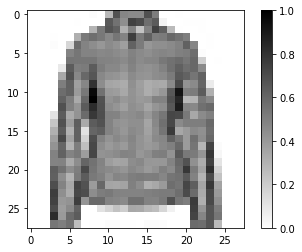

In [7]:
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))

plt.figure()
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Plot a group of images.

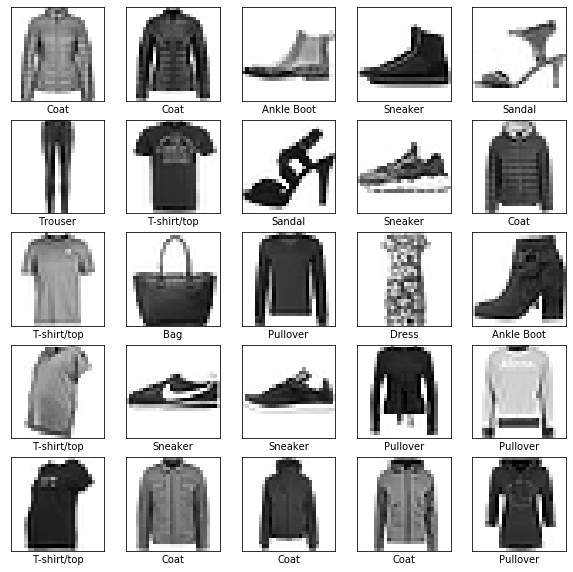

In [8]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5, 5, 1+i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

Okay now that we know what the data looks like, we can start designing the model. 

# Building the Model

## Set up layers

This is going to be a 2-dimensional convolutional neural network, so it will need at least on Conv2d layer. It will also need at least one MaxPooling2D layer. We are going to use two of each. This is how it will go:
* Conv2D
* MaxPooling2D
* Conv2D
* MaxPooling2D
* Flatten
* Dense
* Dense

In [9]:
model = tf.keras.Sequential([
    # 32 is the dimension of the output, (3,3) is the kernel size, 
    # padding must be 'same' or 'valid'
    # uses the REctified Linear Unit activation function
    # input_shape is the dimensions of the input
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                         input_shape = (28, 28, 1)),
    # (2,2) is the window size over which to take the maximum,
    # strides is how far the window moves after pooling
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),
    tf.keras.layers.Flatten(),
    
    # 128 is the dimension of the ouput
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    
    # softmax because this model has multi-factor output
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

## Compile that model!

We will use the 'adam' optimizer, use Sparse Categorical CrossEntropy as the loss function to be optimized, and measure the success of the model using the accuracy metric.

In [10]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

## Train the model

We will let the model train on batches of 32 images at a time. We will store everything in the cache, to speed things up, we will let it repeat for as long as it takes to converge, and we will shuffle the examples so as to reduce memorization.

In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

We will not fit the model on the training data. We will allow it to iterate 10 times (epochs), and tell it to go through the entire training dataset in each iteration (the steps_per_epoch parameter).

In [12]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 83s 44ms/step - loss: 0.4110 - accuracy: 0.8526
Epoch 2/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.2580 - accuracy: 0.9061
Epoch 3/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.2127 - accuracy: 0.92200s - loss: 0
Epoch 4/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.1858 - accuracy: 0.9317
Epoch 5/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.1575 - accuracy: 0.9421
Epoch 6/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.1333 - accuracy: 0.9508
Epoch 7/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.1163 - accuracy: 0.9567
Epoch 8/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.0937 - accuracy: 0.9645
Epoch 9/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0818 - accuracy: 0.9706
Epoch 10/10
1875/1875 [========

Cool. About 90% accuracy on the training data. Now we want to evaluate the model accuracy on the test data.

In [13]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset: ', test_accuracy)

313/313 [==============================] - 7s 21ms/step - loss: 0.2965 - accuracy: 0.9218
Accuracy on test dataset:  0.9218


Hey, 92% ain't bad. 

Let's now try making some predictions and seeing how that goes.

In [14]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)


In [15]:
predictions.shape

(32, 10)

The test prediction is for 32 images; each of the 10 numbers for an image is the confidence that the image is fall into that category. Let's see what the model thinks the first image is.

In [27]:
print("The model predicts that this is a: " + str(class_names[np.argmax(predictions[0])]))
print("It is actually a: " + str(class_names[test_labels[0]]))

The model predicts that this is a: Coat
It is actually a: Coat


That is just excellent. Excellent, excellent work.

In [34]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img=predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[...,0], cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label]),
              color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

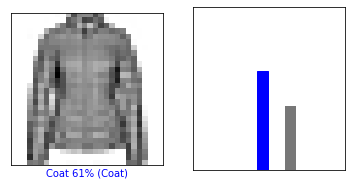

In [37]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

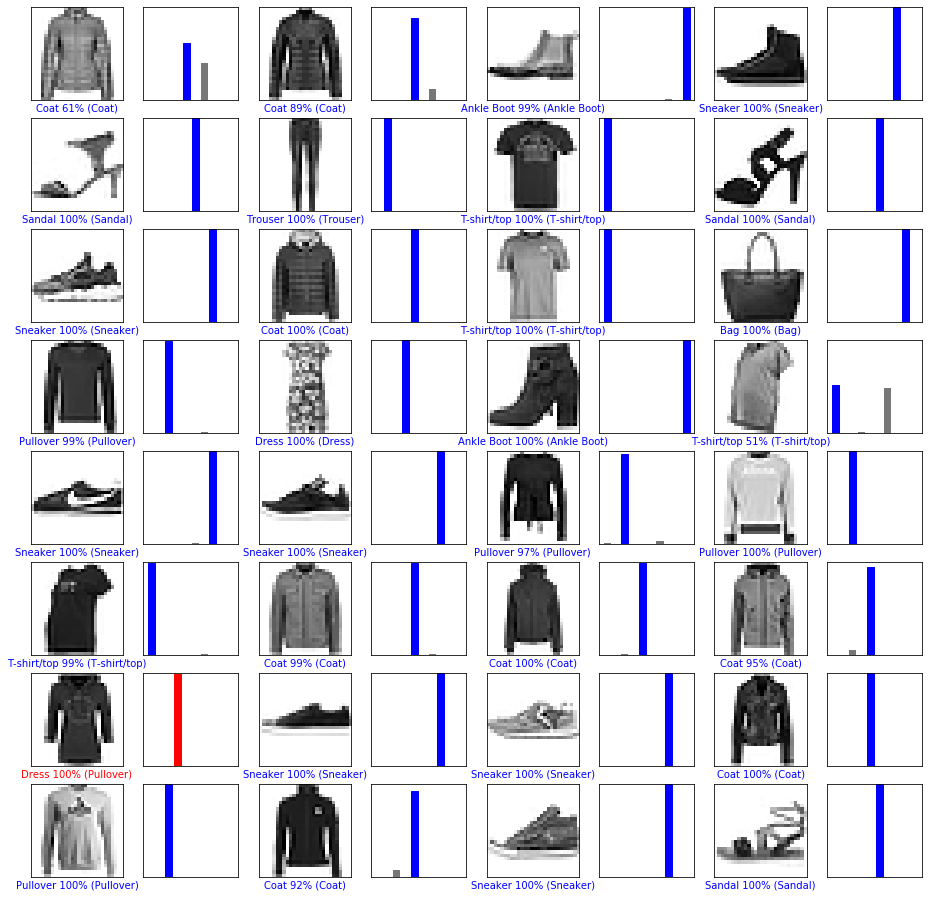

In [41]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

The model quite well, but more importantly it is quite confident every time, even when it is wrong. That can be either good or bad.

Now we want to predict on a single image.

In [44]:
img = test_images[0]
print(img.shape)
img = np.array([img])
print(img.shape)

(28, 28, 1)
(1, 28, 28, 1)


In [45]:
prediction_single = model.predict(img)
print(prediction_single)

[[4.5261032e-07 4.9288136e-08 1.5536886e-04 7.5098538e-12 6.0767245e-01
  8.2648188e-10 3.9217168e-01 3.6892581e-12 1.8513481e-10 3.1618903e-09]]


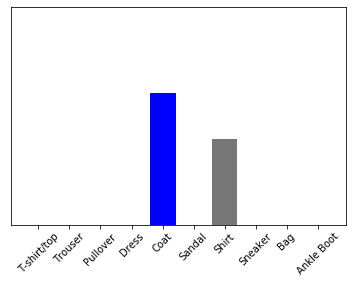

In [46]:
plot_value_array(0, prediction_single, test_labels)
__ = plt.xticks(range(10), class_names, rotation=45)